# MLP GenCode 
Extend MLP_GenCode_105 to show all the stats shown in Wen et al 2019. Here, add AUC for the best model. Still need to add precison, recall, F1, and average test accuracy per fold of training. For now, for comparison to 105, run this on CoLab with a larger validation set. 

In [40]:
import time
def show_time():
    t = time.time()
    print(time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t)))
show_time()

2021-07-19 19:16:18 UTC


In [41]:
PC_TRAINS=8000
NC_TRAINS=8000
PC_TESTS=8000
NC_TESTS=8000   # Wen et al 2019 used 8000 and 2000 of each class
PC_LENS=(200,4000)
NC_LENS=(250,3000)    # Wen et al 2019 used 250-3500 for lncRNA only
MAX_K = 3
INPUT_SHAPE=(None,84)  # 4^3 + 4^2 + 4^1
NEURONS=128
DROP_RATE=0.25
EPOCHS=100 # 25
SPLITS=5
FOLDS=5   # make this 5 for serious testing

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Flatten,TimeDistributed
from keras.losses import BinaryCrossentropy
from keras.callbacks import ModelCheckpoint


In [43]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/GenCodeTools.py')
    with open('GenCodeTools.py', 'w') as f:
        f.write(r.text)  
    from GenCodeTools import GenCodeLoader
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/KmerTools.py')
    with open('KmerTools.py', 'w') as f:
        f.write(r.text)  
    from KmerTools import KmerTools
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.GenCodeTools import GenCodeLoader
        from SimTools.KmerTools import KmerTools
MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

On Google CoLab, mount cloud-local file, get our code from GitHub.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Data Load
Restrict mRNA to those transcripts with a recognized ORF.

In [44]:
PC_FILENAME='gencode.v26.pc_transcripts.fa.gz'
NC_FILENAME='gencode.v26.lncRNA_transcripts.fa.gz'
PC_FULLPATH=DATAPATH+PC_FILENAME
NC_FULLPATH=DATAPATH+NC_FILENAME

In [45]:
loader=GenCodeLoader()
loader.set_label(1)
loader.set_check_utr(False)
pcdf=loader.load_file(PC_FULLPATH)
print("PC seqs loaded:",len(pcdf))
loader.set_label(0)
loader.set_check_utr(False)
ncdf=loader.load_file(NC_FULLPATH)
print("NC seqs loaded:",len(ncdf))
show_time()

PC seqs loaded: 95146
NC seqs loaded: 27720
2021-07-19 19:16:23 UTC


## Data Prep

In [46]:
def dataframe_length_filter(df,low_high):
    (low,high)=low_high
    # The pandas query language is strange, 
    # but this is MUCH faster than loop & drop.
    return df[ (df['seqlen']>=low) & (df['seqlen']<=high) ]
def dataframe_shuffle(df):
    # The ignore_index option is new in Pandas 1.3. 
    # The default (False) replicates the old behavior: shuffle the index too.
    # The new option seems more logical th
    # After shuffling, df.iloc[0] has index == 0.
    # return df.sample(frac=1,ignore_index=True)
    return df.sample(frac=1)  # Use this till CoLab upgrades Pandas
def dataframe_extract_sequence(df):
    return df['sequence'].tolist()

pc_all = dataframe_extract_sequence(
    #dataframe_shuffle(
    dataframe_length_filter(pcdf,PC_LENS))#)
nc_all = dataframe_extract_sequence(
    #dataframe_shuffle(
    dataframe_length_filter(ncdf,NC_LENS))#)

#pc_all=['CAAAA','CCCCC','AAAAA','AAACC','CCCAA','CAAAA','CCCCC','AACAA','AAACC','CCCAA']
#nc_all=['GGGGG','TTTTT','GGGTT','GGGTG','TTGTG','GGGGG','TTTTT','GGTTT','GGGTG','TTGTG']

show_time()
print("PC seqs pass filter:",len(pc_all))
print("NC seqs pass filter:",len(nc_all))
# Garbage collection to reduce RAM footprint
pcdf=None
ncdf=None

2021-07-19 19:16:23 UTC
PC seqs pass filter: 82256
NC seqs pass filter: 25755


In [47]:
# Any portion of a shuffled list is a random selection
pc_train=pc_all[:PC_TRAINS] 
nc_train=nc_all[:NC_TRAINS]
pc_test=pc_all[PC_TRAINS:PC_TRAINS+PC_TESTS] 
nc_test=nc_all[NC_TRAINS:NC_TRAINS+PC_TESTS]
print("PC train, NC train:",len(pc_train),len(nc_train))
print("PC test, NC test:",len(pc_test),len(nc_test))
# Garbage collection
pc_all=None
nc_all=None

PC train, NC train: 8000 8000
PC test, NC test: 8000 8000


In [48]:
def prepare_x_and_y(seqs1,seqs0):
    len1=len(seqs1)
    len0=len(seqs0)
    total=len1+len0
    L1=np.ones(len1,dtype=np.int8)
    L0=np.zeros(len0,dtype=np.int8)
    S1 = np.asarray(seqs1)
    S0 = np.asarray(seqs0)
    all_labels = np.concatenate((L1,L0))
    all_seqs = np.concatenate((S1,S0))  
    return all_seqs,all_labels  # use this to test unshuffled
    # bug in next line?
    X,y = shuffle(all_seqs,all_labels) # sklearn.utils.shuffle 
    #Doesn't fix it
    #X = shuffle(all_seqs,random_state=3) # sklearn.utils.shuffle 
    #y = shuffle(all_labels,random_state=3) # sklearn.utils.shuffle 
    return X,y
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print(Xseq[:3])
print(y[:3])
# Tests:
show_time()

['ATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTCTATGGAGGAATCGTGTTTGGAAACCTTCTTATTGTCATAACAGTGGTATCTGACTCCCACCTTCACTCTCCCATGTACTTCCTGCTAGCCAACCTCTCACTCATTGATCTGTCTCTGTCTTCAGTCACAGCCCCCAAGATGATTACTGACTTTTTCAGCCAGCGCAAAGTCATCTCTTTCAAGGGCTGCCTTGTTCAGATATTTCTCCTTCACTTCTTTGGTGGGAGTGAGATGGTGATCCTCATAGCCATGGGCTTTGACAGATATATAGCAATATGCAAGCCCCTACACTACACTACAATTATGTGTGGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCTTTCTCCATTCGGTGAGCCAGTTGGCGTTTGCCGTGCACTTACTCTTCTGTGGTCCCAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAACTTGCCTGTACAGATACCTACAGGCTAGATATTATGGTCATTGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATCATCTCATACACTATCATCCTAATGACCATCCAGCATCGCCCTTTAGATAAGTCGTCCAAAGCTCTGTCCACTTTGACTGCTCACATTACAGTAGTTCTTTTGTTCTTTGGACCATGTGTCTTTATTTATGCCTGGCCATTCCCCATCAAGTCATTAGATAAATTCCTTGCTGTATTTTATTCTGTGATCACCCCTCTCTTGAACCCAATTATATACACACTGAGGAACAAAGACATGAAGACGGCAATAAGACAGCTGAGAAAATGGGATGCACATTCTAGTGTAAAGTTTTAG'
 'ATGGATGGAGAGAATCACTCAGTGGTATCTGAGTTTTTGTTTCTGGGACTCACTCATTCATGGGAGATCCAGCTCC

In [49]:
def seqs_to_kmer_freqs(seqs,max_K):
    tool = KmerTools()  # from SimTools
    empty = tool.make_dict_upto_K(max_K)
    collection = []
    for seq in seqs:
        counts = empty
        # Last param should be True when using Harvester.
        counts = tool.update_count_one_K(counts,max_K,seq,True)
        # Given counts for K=3, Harvester fills in counts for K=1,2.
        counts = tool.harvest_counts_from_K(counts,max_K)
        fdict = tool.count_to_frequency(counts,max_K)
        freqs = list(fdict.values())
        collection.append(freqs)
    return np.asarray(collection)
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
show_time()

2021-07-19 19:16:33 UTC


## Neural network

In [50]:
def make_DNN():
    dt=np.float32
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt))  # relu doesn't work as well
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=dt)) 
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=dt))   
    dnn.compile(optimizer='adam',    # adadelta doesn't work as well
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE) 
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (None, 84)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               10880     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 27,521
Trainable params: 27,521
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS,shuffle=True)
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 2s 3ms/step - loss: 0.7149 - accuracy: 0.5003 - val_loss: 0.6896 - val_accuracy: 0.5019
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6950 - accuracy: 0.5250 - val_loss: 0.6742 - val_accuracy: 0.5019
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6762 - accuracy: 0.5750 - val_loss: 0.6083 - val_accuracy: 0.6872
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6112 - accuracy: 0.6604 - val_loss: 0.4748 - val_accuracy: 0.9631
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.5277 - accuracy: 0.7273 - val_loss: 0.3935 - val_accuracy: 0.9344
Epoch 6/100
400/400 [==============================] - 1s 2ms/step - loss: 0.4785 - ac

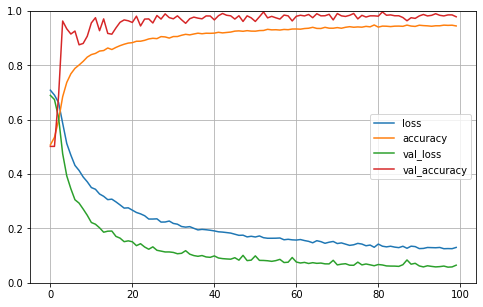

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 2s 3ms/step - loss: 0.7112 - accuracy: 0.5047 - val_loss: 0.6870 - val_accuracy: 0.5312
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6903 - accuracy: 0.5329 - val_loss: 0.6744 - val_accuracy: 0.5047
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6733 - accuracy: 0.5785 - val_loss: 0.6036 - val_accuracy: 0.6791
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6019 - accuracy: 0.6724 - val_loss: 0.4706 - val_accuracy: 0.8394
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.5309 - accuracy: 0.7203 - val_loss: 0.4000 - val_accuracy: 0.9528
Epoch 6/100
400/400 [==============================] - 1s 2ms/step - loss: 0.4667 - accuracy: 0.7667 - val_loss: 0.3640 - val_accuracy: 0.8272
Epoch 7/100
400/400 [==============================] - 1s 2ms/step - loss: 0.4396 - accuracy: 0.781

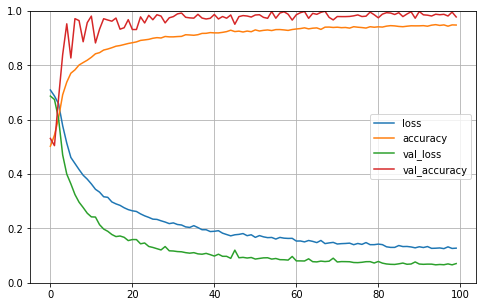

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 2s 3ms/step - loss: 0.7133 - accuracy: 0.4942 - val_loss: 0.6869 - val_accuracy: 0.5097
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5325 - val_loss: 0.6706 - val_accuracy: 0.4919
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6681 - accuracy: 0.5875 - val_loss: 0.5839 - val_accuracy: 0.7544
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6003 - accuracy: 0.6716 - val_loss: 0.4652 - val_accuracy: 0.8450
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.5220 - accuracy: 0.7292 - val_loss: 0.3959 - val_accuracy: 0.9187
Epoch 6/100
400/400 [==============================] - 1s 2ms/step - loss: 0.4734 - accuracy: 0.7624 - val_loss: 0.3622 - val_accuracy: 0.8316
Epoch 7/100
400/400 [==============================] - 1s 2ms/step - loss: 0.4420 - accuracy: 0.778

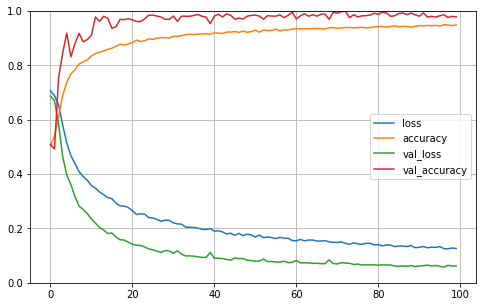

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 2s 3ms/step - loss: 0.7220 - accuracy: 0.5066 - val_loss: 0.6901 - val_accuracy: 0.4978
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6944 - accuracy: 0.5218 - val_loss: 0.6817 - val_accuracy: 0.4978
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6682 - accuracy: 0.5925 - val_loss: 0.5901 - val_accuracy: 0.7228
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6014 - accuracy: 0.6711 - val_loss: 0.4720 - val_accuracy: 0.9550
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.5203 - accuracy: 0.7352 - val_loss: 0.4028 - val_accuracy: 0.8344
Epoch 6/100
400/400 [==============================] - 1s 2ms/step - loss: 0.4759 - accuracy: 0.7608 - val_loss: 0.3647 - val_accuracy: 0.8438
Epoch 7/100
400/400 [==============================] - 1s 2ms/step - loss: 0.4406 - accuracy: 0.785

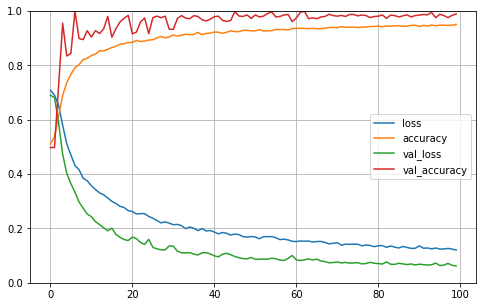

MODEL
make_DNN
input shape: (None, 84)
FIT
Epoch 1/100
400/400 [==============================] - 2s 3ms/step - loss: 0.7111 - accuracy: 0.5034 - val_loss: 0.6877 - val_accuracy: 0.4994
Epoch 2/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6909 - accuracy: 0.5277 - val_loss: 0.6732 - val_accuracy: 0.5350
Epoch 3/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6635 - accuracy: 0.5987 - val_loss: 0.5801 - val_accuracy: 0.8697
Epoch 4/100
400/400 [==============================] - 1s 2ms/step - loss: 0.6036 - accuracy: 0.6736 - val_loss: 0.4685 - val_accuracy: 0.9134
Epoch 5/100
400/400 [==============================] - 1s 2ms/step - loss: 0.5212 - accuracy: 0.7356 - val_loss: 0.3967 - val_accuracy: 0.8409
Epoch 6/100
400/400 [==============================] - 1s 2ms/step - loss: 0.4796 - accuracy: 0.7620 - val_loss: 0.3481 - val_accuracy: 0.9047
Epoch 7/100
400/400 [==============================] - 1s 2ms/step - loss: 0.4378 - accuracy: 0.781

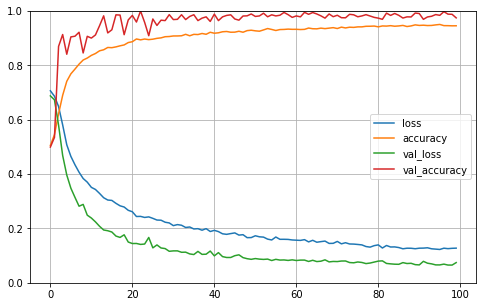

In [52]:
do_cross_validation(Xfrq,y)

In [53]:
from keras.models import load_model
print(pc_train[0])
Xseq,y=prepare_x_and_y(pc_train,nc_train)
print(Xseq[0])
Xfrq=seqs_to_kmer_freqs(Xseq,MAX_K)
print(Xfrq[0])
X=Xfrq
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))

ATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTCTATGGAGGAATCGTGTTTGGAAACCTTCTTATTGTCATAACAGTGGTATCTGACTCCCACCTTCACTCTCCCATGTACTTCCTGCTAGCCAACCTCTCACTCATTGATCTGTCTCTGTCTTCAGTCACAGCCCCCAAGATGATTACTGACTTTTTCAGCCAGCGCAAAGTCATCTCTTTCAAGGGCTGCCTTGTTCAGATATTTCTCCTTCACTTCTTTGGTGGGAGTGAGATGGTGATCCTCATAGCCATGGGCTTTGACAGATATATAGCAATATGCAAGCCCCTACACTACACTACAATTATGTGTGGCAACGCATGTGTCGGCATTATGGCTGTCACATGGGGAATTGGCTTTCTCCATTCGGTGAGCCAGTTGGCGTTTGCCGTGCACTTACTCTTCTGTGGTCCCAATGAGGTCGATAGTTTTTATTGTGACCTTCCTAGGGTAATCAAACTTGCCTGTACAGATACCTACAGGCTAGATATTATGGTCATTGCTAACAGTGGTGTGCTCACTGTGTGTTCTTTTGTTCTTCTAATCATCTCATACACTATCATCCTAATGACCATCCAGCATCGCCCTTTAGATAAGTCGTCCAAAGCTCTGTCCACTTTGACTGCTCACATTACAGTAGTTCTTTTGTTCTTTGGACCATGTGTCTTTATTTATGCCTGGCCATTCCCCATCAAGTCATTAGATAAATTCCTTGCTGTATTTTATTCTGTGATCACCCCTCTCTTGAACCCAATTATATACACACTGAGGAACAAAGACATGAAGACGGCAATAAGACAGCTGAGAAAATGGGATGCACATTCTAGTGTAAAGTTTTAG
ATGGTGACTGAATTCATTTTTCTGGGTCTCTCTGATTCTCAGGAACTCCAGACCTTCCTATTTATGTTGTTTTTTGTATTC

predictions.shape (16000, 1)
first prediction [3.0398806e-07]


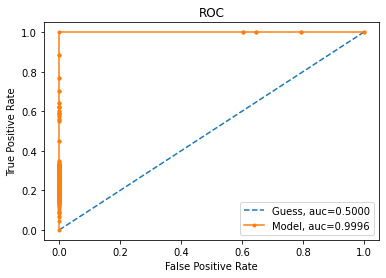

AUC: 99.96%


In [54]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
print("predictions.shape",bm_probs.shape)
print("first prediction",bm_probs[0])
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))
